# Appendix - misc

This notebook contains many miscellaneous analyses which were also performed but not included in the supplemental material of the paper.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sys

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

## Hospital mortality as the outcome

### Binormal ROC

All the scores evaluated are heavily quantized: there are usually very few possible values. As a result, the empirical ROC curve is likely to underestimate the "true" ROC curve if one could hypothetically evaluate the scores at all possible values.

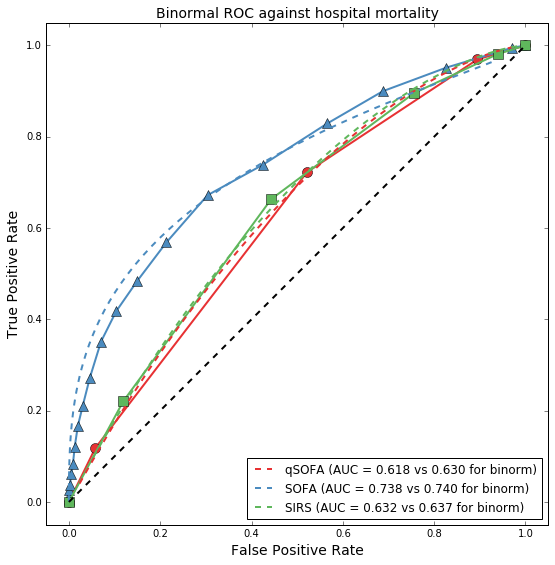

In [2]:
## Comparing binormal and empirical ROC
y = df.hospital_expire_flag.values == 1
plt.figure(figsize=[9,9])

# === NORMAL EMPIRICALLY DERIVED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, 'o-',
         color=col[0], linewidth=2, markersize=10)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10)


# === BINORMAL ESTIMATED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = ru.binormal_roc(df.qsofa.values[y], df.qsofa.values[~y])
auc_qsofa2 = ru.binormal_auroc(df.qsofa.values[y], df.qsofa.values[~y])

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = ru.binormal_roc(df.sofa.values[y], df.sofa.values[~y])
auc_sofa2 = ru.binormal_auroc(df.sofa.values[y], df.sofa.values[~y])

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = ru.binormal_roc(df.sirs.values[y], df.sirs.values[~y])
auc_sirs2 = ru.binormal_auroc(df.sirs.values[y], df.sirs.values[~y])

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, '--',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_qsofa, auc_qsofa2))
plt.plot(fpr_sofa, tpr_sofa, '--',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_sofa, auc_sofa2))
plt.plot(fpr_sirs, tpr_sirs, '--',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_sirs, auc_sirs2))

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Binormal ROC against hospital mortality',fontsize=14)
plt.show()

### Histograms comparing qSOFA in survivors and non-survivors

Histograms comparing survivors and non-survivors - *normalized*


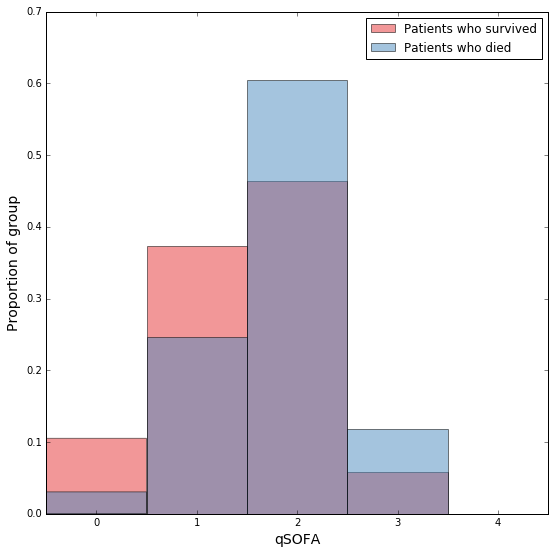

Histograms comparing survivors and non-survivors - *not normalized*


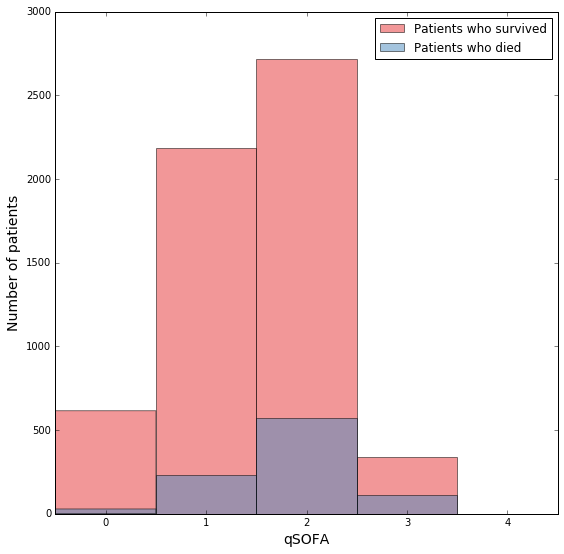

In [3]:
print('Histograms comparing survivors and non-survivors - *normalized*')
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

# plot the data
plt.figure(figsize=[9,9])
plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='Patients who survived')
plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='Patients who died')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Proportion of group',fontsize=14)
plt.show()

print('Histograms comparing survivors and non-survivors - *not normalized*')
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

prevalence = np.mean(y)

# plot the data
plt.figure(figsize=[9,9])
n0, bins0, patches0 = plt.hist(qsofa_alive, bins=xi, normed=False, color=col[0], alpha=0.5,
         label='Patients who survived')
n1, bins1, patches1 = plt.hist(qsofa_dead, bins=xi, normed=False, color=col[1], alpha=0.5,
         label='Patients who died')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Number of patients',fontsize=14)
#plt.title('ROC against hospital mortality',fontsize=14)
plt.show()

## Sepsis as the outcome

In [4]:
# define outcome
target_header = "angus"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

### What is NTP/NFP?

In addition to the normal operating point statistics, we evaluate the number of false positives per 100 cases, or NFP/100. We feel this gives helpful perspective in interpretting the positive predictive value of the prediction and its relationship to the prevalance of the outcome. In this context, the measure can be summarized as: given 100 patients with suspected infection, how many will each algorithm **inappropriately** give a positive prediction?

In [5]:
# example of NFP/100
N_PATIENTS = 100
score_name = 'sepsis3'

FP = np.sum( (df[score_name]==1) & (df[target_header]==0) ).astype(float)
TP = np.sum( (df[score_name]==1) & (df[target_header]==1) ).astype(float)
N = df.shape[0]

score_pos = (FP+TP)/N
score_ppv = TP/(TP+FP)

N_POSITIVES = N_PATIENTS*score_pos
print('For {:2.2f} patients, {:2.2f} positives.'.format(N_PATIENTS, N_POSITIVES))
print('Of the {:2.2f} positives, {:2.2f} are **false**.'.format(N_POSITIVES, N_POSITIVES*(1-score_ppv)))

For 100.00 patients, 50.78 positives.
Of the 50.78 positives, 21.70 are **false**.


A similar question can be asked: given 100 patients with suspected infection, how many will each algorithm **appropriately** give a positive prediction?

In [6]:
# example of NTP/100
print('For {:2.2f} patients, {:2.2f} positives.'.format(N_PATIENTS, N_POSITIVES))
print('Of the {:2.2f} positives, {:2.2f} are **true**.'.format(N_POSITIVES, N_POSITIVES*(score_ppv)))

For 100.00 patients, 50.78 positives.
Of the 50.78 positives, 29.08 are **true**.


This is how the NTP and NFP are calculated.

In [7]:
print('NFP (per 100 cases) = {:2.2f}'.format(N_POSITIVES*(1-score_ppv)))
print('NTP (per 100 cases) = {:2.2f}'.format(N_POSITIVES*(score_ppv)))

NFP (per 100 cases) = 21.70
NTP (per 100 cases) = 29.08


### ROC curve for sepsis prediction

Here we reproduce the ROC curves for sepsis prediction using the empirical calculation (i.e. not using the binormal model).

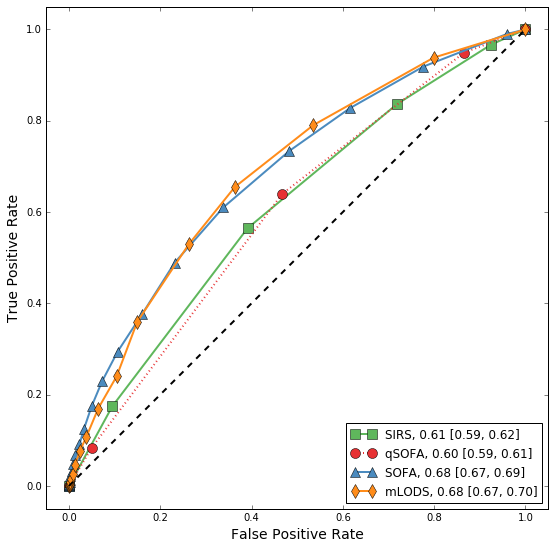

In [8]:
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'mLODS'}

# plot the data
plt.figure(figsize=[9,9])

# calculate and plot ROC for each score
for pred in ['sirs','qsofa','sofa','mlods']:
    if pred=='sepsis3':
        continue
        
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)

# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
#plt.title('ROC against ' + target_header,fontsize=14)
plt.show()

## Histograms comparing qSOFA

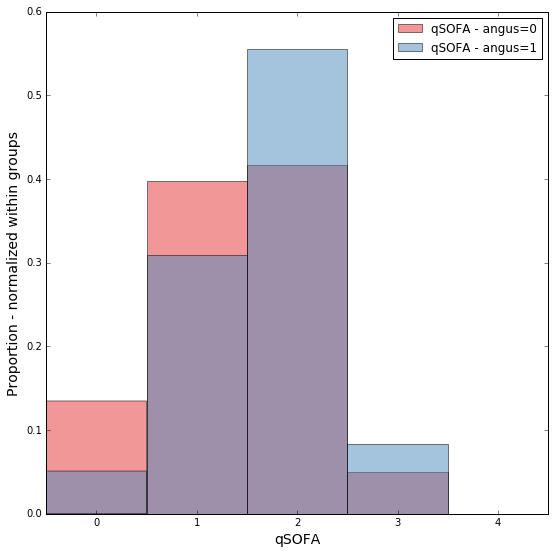

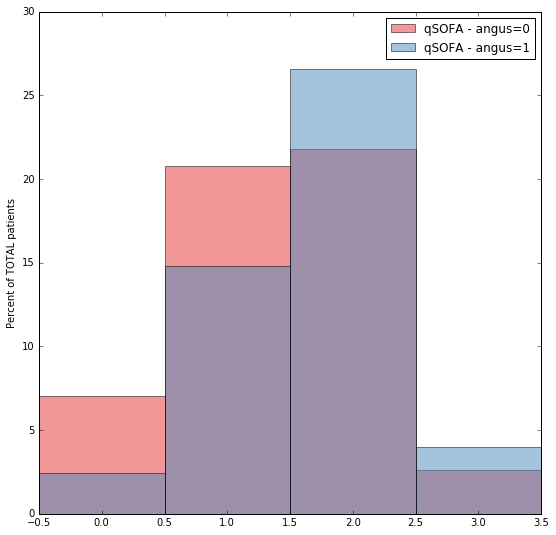

In [9]:
# histogram of the qSOFA values in septic/non-septic population
qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

prevalence = np.mean(y)

# plot the data
plt.figure(figsize=[9,9])
n0, bins0, patches0 = plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='qSOFA - ' + target_header + '=0')
n1, bins1, patches1 = plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='qSOFA - ' + target_header + '=1')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Proportion - normalized within groups',fontsize=14)

plt.figure(figsize=[9,9])

N = len(y)
plt.bar(bins0[0:-1], 100.0*n0/N*qsofa_alive.shape[0], width=1, color=col[0], alpha=0.5,
         label='qSOFA - ' + target_header + '=0')
plt.bar(bins1[0:-1], 100.0*n1/N*qsofa_dead.shape[0], width=1, color=col[1], alpha=0.5,
         label='qSOFA - ' + target_header + '=1')
plt.legend()
plt.ylabel('Percent of TOTAL patients')
plt.show()